# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.memory", "6g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")
conf.set("spark.executor.instances", "2")
conf.set("spark.executor.cores", "4")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 4)
# conf.set("spark.dynamicAllocation.maxExecutors", 8)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!ls ../..

apache_spark  data.zip	hadoop_map_reduce  __MACOSX   spark_sql
data	      docker	intro		   README.md


In [5]:
!hdfs dfs -copyFromLocal ../../data .

copyFromLocal: `data/.DS_Store': File exists
copyFromLocal: `data/ml-25m/README.txt': File exists
copyFromLocal: `data/ml-25m/genome-scores.csv': File exists
copyFromLocal: `data/ml-25m/genome-tags.csv': File exists
copyFromLocal: `data/ml-25m/links.csv': File exists
copyFromLocal: `data/ml-25m/ml-25m-README.htm': File exists
copyFromLocal: `data/ml-25m/movies.csv': File exists
copyFromLocal: `data/ml-25m/ratings.csv': File exists
copyFromLocal: `data/ml-25m/tags.csv': File exists
copyFromLocal: `data/ml-25m/tmdb.json': File exists


In [6]:
!hdfs dfs -ls data/ml-25m/

Found 10 items
-rw-r--r--   1 root supergroup      10460 2020-02-04 19:33 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-02-04 19:33 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-02-04 19:33 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-02-04 19:33 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-02-04 19:33 data/ml-25m/ml-25m-README.htm
drwxr-xr-x   - root supergroup          0 2020-02-04 19:39 data/ml-25m/movie_avg_rating
-rw-r--r--   1 root supergroup    3038099 2020-02-04 19:33 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-02-04 19:33 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-02-04 19:33 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-02-04 19:33 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [7]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [8]:
ratings = sc.textFile(RATINGS_PATH)

In [9]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [10]:
ratings.getNumPartitions()

5

In [11]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [12]:
%%time

ratings.count()

CPU times: user 11.7 ms, sys: 7.62 ms, total: 19.3 ms
Wall time: 57.9 s


25000095

Количество пользователей

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 20 ms, sys: 6.69 ms, total: 26.7 ms
Wall time: 1min 9s


162541

Сохраним датасет в память

In [14]:
ratings = ratings.persist()

In [15]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 24.6 ms, sys: 8.23 ms, total: 32.8 ms
Wall time: 1min 52s


162541

Количество фильмов

In [16]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [17]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [18]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

In [24]:
!ls ../../data/ml-25m/

genome-scores.csv  links.csv	      movies.csv   README.txt  tmdb.json
genome-tags.csv    ml-25m-README.htm  ratings.csv  tags.csv


Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [27]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [28]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-02-05 02:54 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2020-02-05 02:54 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2020-02-05 02:54 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2020-02-05 02:54 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2020-02-05 02:54 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2020-02-05 02:54 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2020-02-05 02:54 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2020-02-05 02:54 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2020-02-05 02:54 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2020-02-05 02:54 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [29]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [30]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [31]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

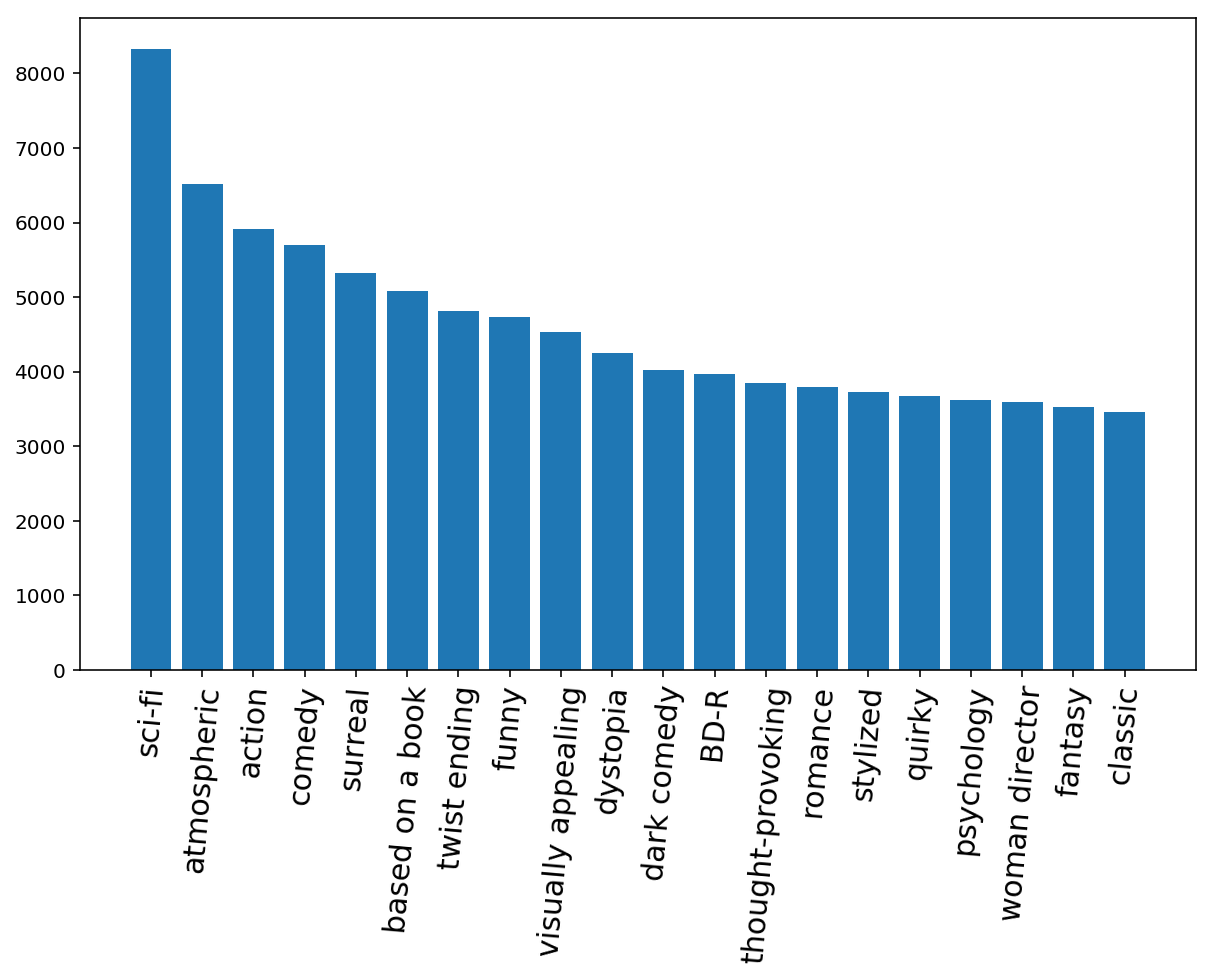

In [32]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [33]:
%%time

marks_counts = ratings\
    .map(lambda user_mark: (user_mark.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .join(movies)\
    .map(lambda key_value: (key_value[1][1][1], key_value[1][0]))\
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(10)

CPU times: user 54.1 ms, sys: 12.9 ms, total: 67 ms
Wall time: 32.6 s


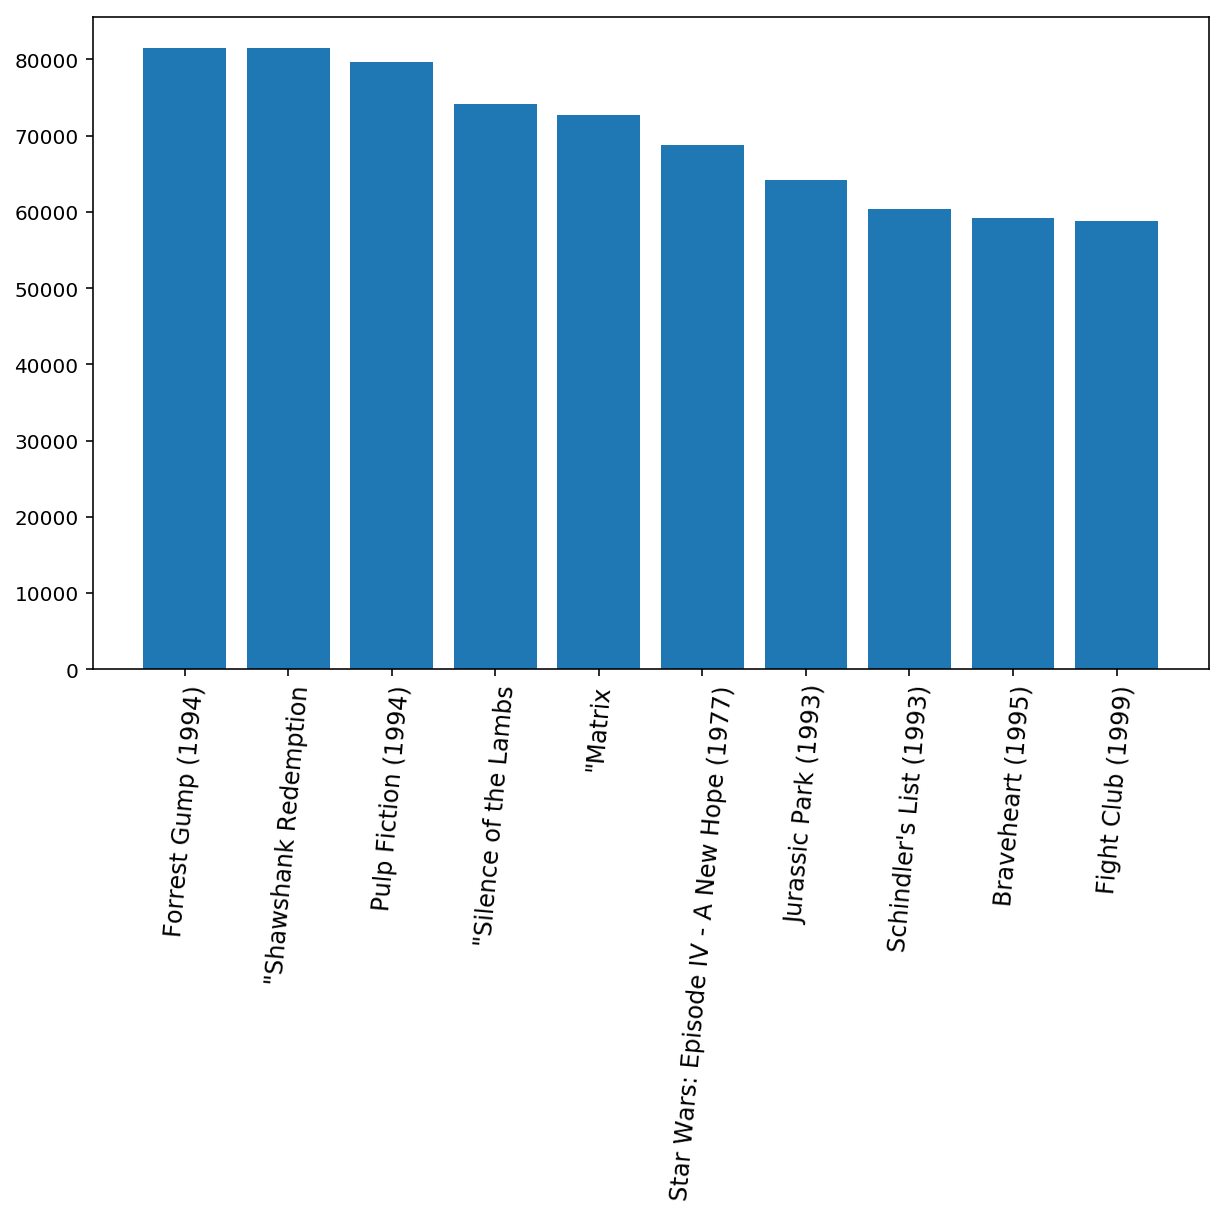

In [34]:
keys, values = zip(*marks_counts)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=12)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [35]:
%%time

best_marks_counts = ratings\
    .filter(lambda user_mark: user_mark.rating == 5)\
    .map(lambda user_mark: (user_mark.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .join(movies)\
    .map(lambda key_value: (key_value[1][1][1], key_value[1][0]))\
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(10)

CPU times: user 58.9 ms, sys: 740 µs, total: 59.7 ms
Wall time: 27.6 s


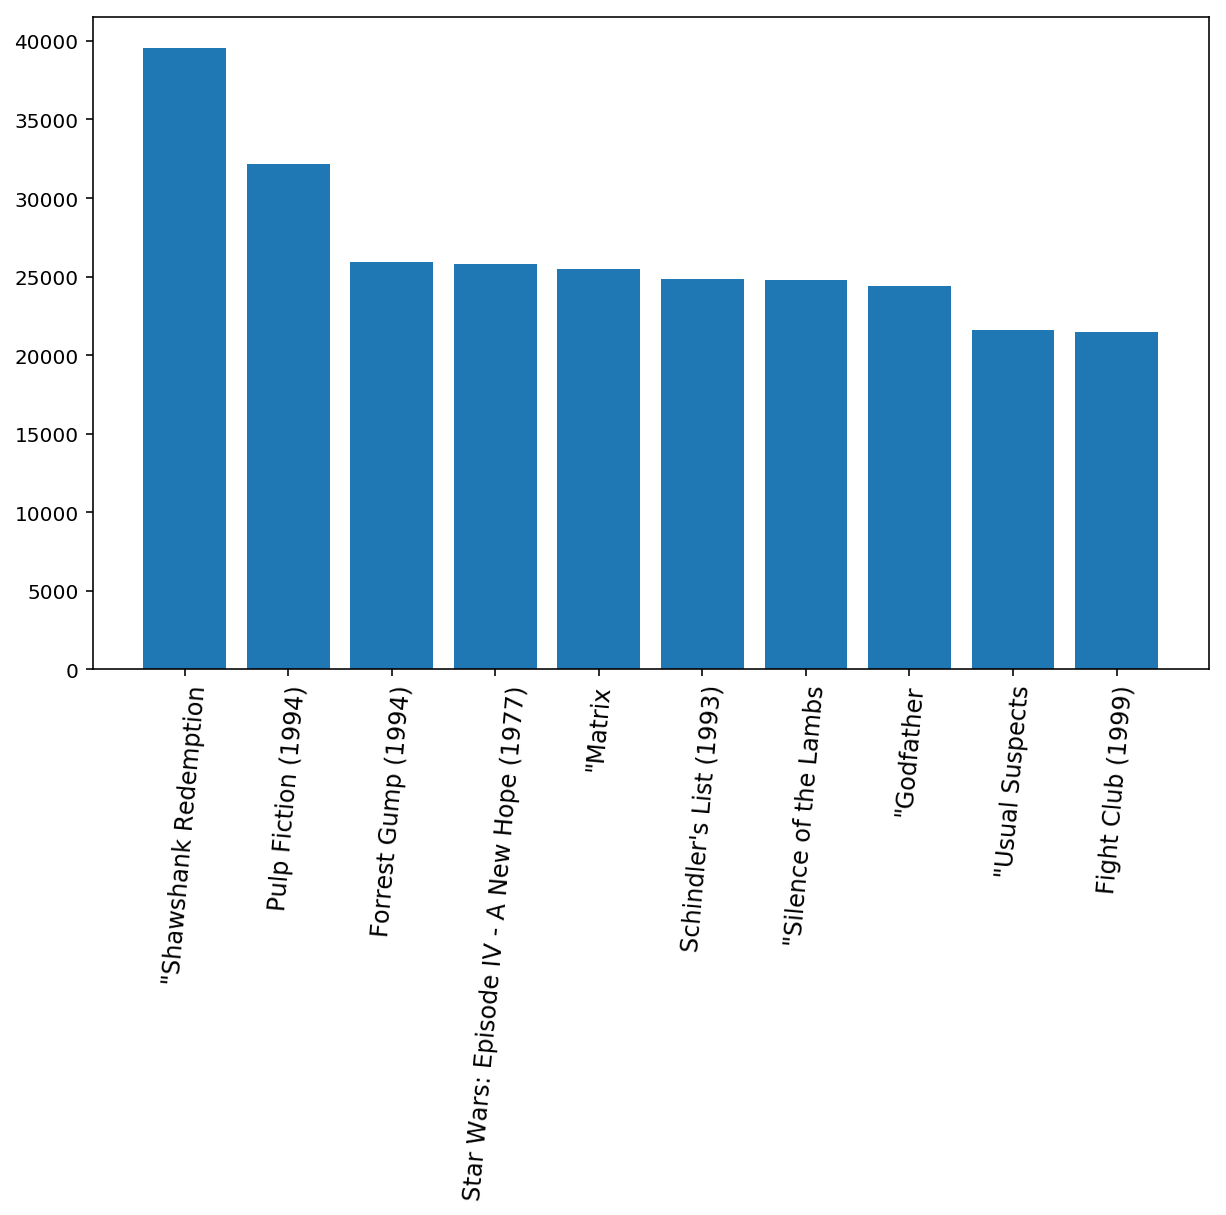

In [36]:
keys, values = zip(*best_marks_counts)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=12)
plt.bar(keys, values, align="center")
plt.show()

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [37]:
%%time

rating_hist = movie_avg_rating\
    .map(lambda key_value: (round(key_value[1], 1), 1))\
    .reduceByKey(lambda a, b: a + b)\
    .sortByKey()\
    .collect()

CPU times: user 31.4 ms, sys: 6.17 ms, total: 37.6 ms
Wall time: 740 ms


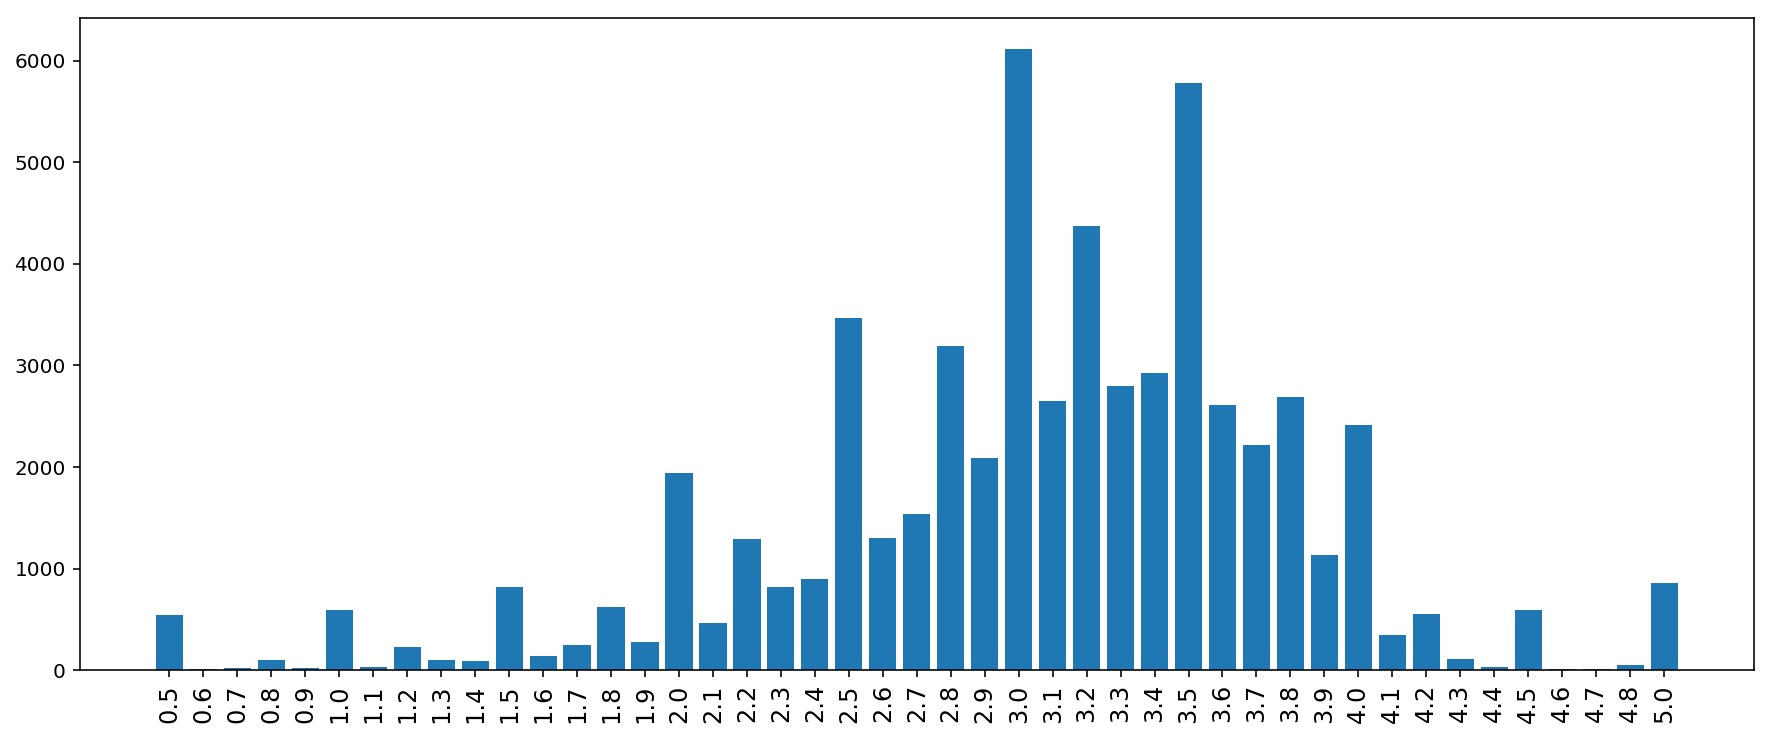

In [38]:
keys, values = zip(*rating_hist)
keys = [str(key) for key in keys]

f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation=90, fontsize=12)
plt.bar(keys, values, align="center")
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [39]:
from math import log10, ceil

In [40]:
%%time

marks_counts_hist = ratings\
    .map(lambda user_mark: (user_mark.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .map(lambda key_value: (ceil(log10(key_value[1])), 1))\
    .reduceByKey(lambda a, b: a + b)\
    .sortByKey()\
    .collect()

CPU times: user 36.5 ms, sys: 12 ms, total: 48.5 ms
Wall time: 31.1 s


In [41]:
len(marks_counts_hist)

6

In [42]:
print(marks_counts_hist)

[(0, 10298), (1, 25392), (2, 13066), (3, 6501), (4, 3202), (5, 588)]


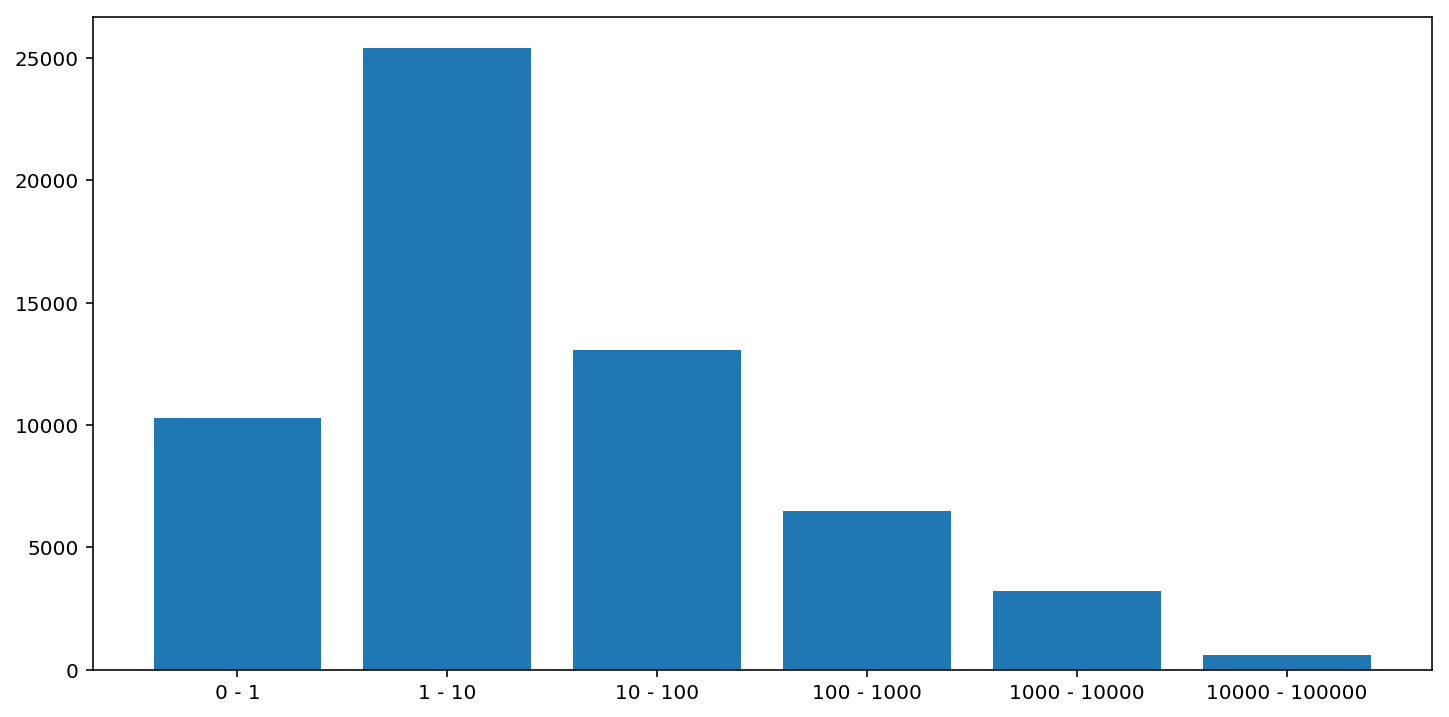

In [43]:
keys, values = zip(*marks_counts_hist)
pow_10 = ["0"] + [str(pow(10, key)) for key in keys]
x_labels = [a + " - " + b for (a, b) in zip(pow_10[:-1], pow_10[1:])]

f, ax = plt.subplots(figsize=(12, 6))
plt.bar(x_labels, values, align="center")
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [44]:
%%time

topics = sc.textFile(MOVIES_PATH)\
    .map(lambda s: s.split(',')[-1])\
    .flatMap(lambda s: [] if not s or s == 'genres' else s.split("|"))\
    .map(lambda t: (t, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .sortByKey()\
    .collect()

CPU times: user 27.5 ms, sys: 9.71 ms, total: 37.2 ms
Wall time: 533 ms


In [45]:
print(topics)

[('(no genres listed)', 5062), ('Action', 7348), ('Adventure', 4145), ('Animation', 2929), ('Children', 2935), ('Comedy', 16870), ('Crime', 5319), ('Documentary', 5605), ('Drama', 25606), ('Fantasy', 2731), ('Film-Noir', 353), ('Horror', 5989), ('IMAX', 195), ('Musical', 1054), ('Mystery', 2925), ('Romance', 7719), ('Sci-Fi', 3595), ('Thriller', 8654), ('War', 1874), ('Western', 1399)]


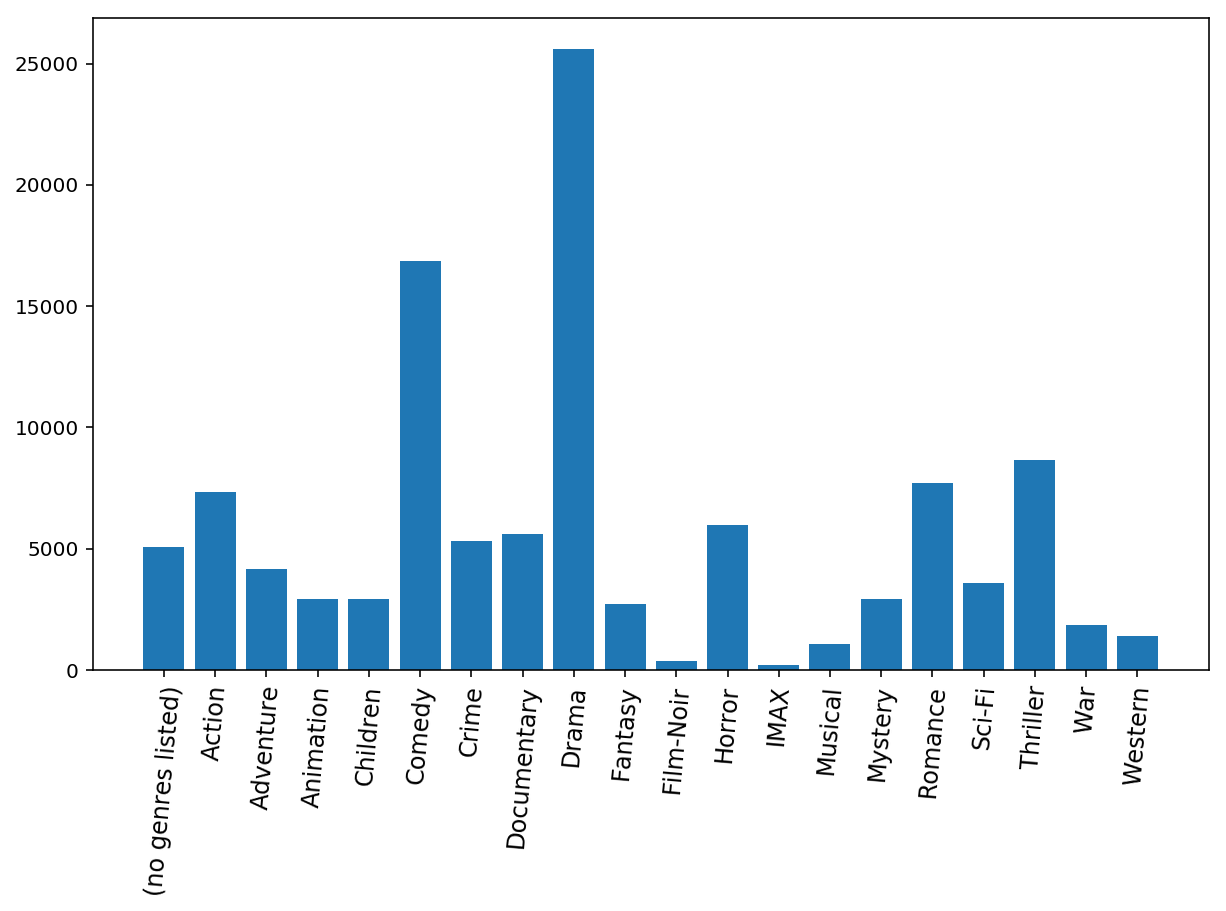

In [46]:
keys, values = zip(*topics)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=12)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [47]:
import json

In [48]:
# movieId,imdbId,tmdbId
links = sc.textFile(LINKS_PATH)\
    .map(lambda s: s.split(","))\
    .filter(lambda tokens: tokens[0].isdigit() and tokens[1].isdigit() and tokens[2].isdigit())\
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2])))

In [49]:
tmdb_to_id = links.map(lambda data: (data[2], data[0]))

In [50]:
tmdb = sc.textFile(TMDB_PATH)\
    .map(lambda s: json.loads(s))

In [51]:
# actorId,actorName,movieId,movieName
actors = tmdb\
    .filter(lambda data: "id" in data)\
    .map(lambda data: (data["id"], data["casts"]["cast"]))\
    .join(tmdb_to_id)\
    .flatMap(lambda key_value: [(actor["id"], actor["name"], key_value[1][1]) for actor in key_value[1][0]])\
    .keyBy(lambda row: row[2])\
    .join(movies)\
    .map(lambda data: (data[1][0][0], data[1][0][1], data[0], data[1][1][1]))

In [52]:
%%time

hanks_films = actors\
    .filter(lambda data: data[0] == 31)\
    .map(lambda data: data[3])\
    .collect()

CPU times: user 12.7 ms, sys: 703 µs, total: 13.4 ms
Wall time: 11 s


In [53]:
print(hanks_films)

['Sleepless in Seattle (1993)', '"Celluloid Closet', 'Every Time We Say Goodbye (1986)', 'Elvis Has Left the Building (2004)', '"League of Their Own', 'Captain Phillips (2013)', 'Toy Story of Terror (2013)', 'Shooting War (2000)', 'Killing Lincoln (2013)', '"\'burbs', 'Splash (1984)', 'Toy Story (1995)', 'And the Oscar Goes To... (2014)', 'Bonfire of the Vanities (1990)', 'Punchline (1988)', 'Turner & Hooch (1989)', '"Simpsons Movie', 'Larry Crowne (2011)', 'Toy Story Toons: Small Fry (2011)', '"Man with One Red Shoe', 'Toy Story 3 (2010)', 'Sully (2016)', 'Mazes and Monsters (1982)', 'Magnificent Desolation: Walking on the Moon (2005)', 'The Post (2017)', '"Money Pit', "You've Got Mail (1998)", 'Toy Story 4 (2019)', 'California Typewriter (2017)', 'Radio Flyer (1992)', 'Apollo 13 (1995)', '"Pixar Story', '"Terminal', 'Nothing in Common (1986)', 'Angels & Demons (2009)', '"The Mayo Clinic', "He Knows You're Alone (a.k.a. Blood Wedding) (1980)", '"Ladykillers', 'Extremely Loud and Incre

In [54]:
top_actors = actors\
    .map(lambda data: (data[1], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda data: data[1], ascending=False)\
    .take(10)

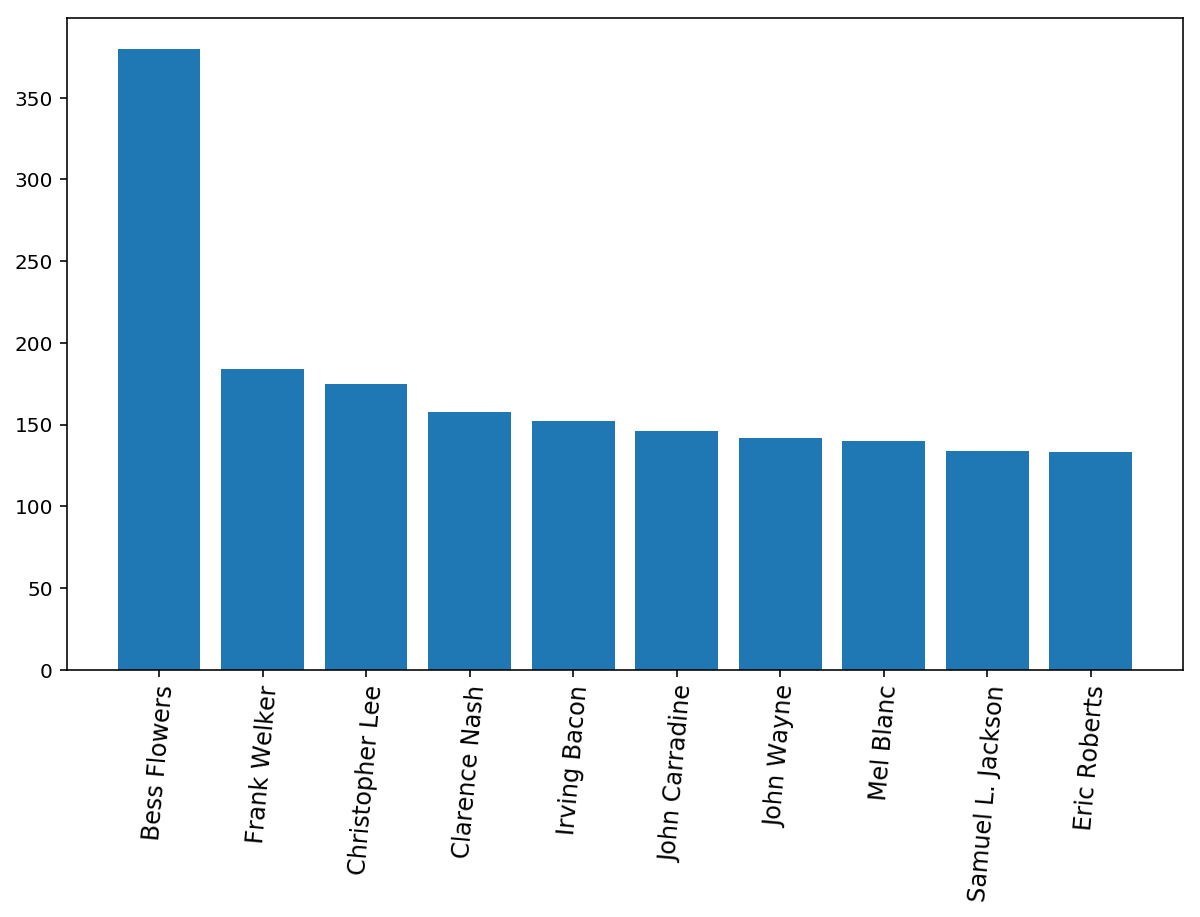

In [55]:
keys, values = zip(*top_actors)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=12)
plt.bar(keys, values, align="center")
plt.show()

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [56]:
import numpy as np

In [57]:
from_year = 1950
to_year = 2018

In [58]:
movie_to_year = tmdb\
    .filter(lambda data: "id" in data and data["release_date"])\
    .map(lambda data: (data["id"], int(data["release_date"][:4])))\
    .join(tmdb_to_id)\
    .map(lambda data: (data[1][1], data[1][0]))

In [59]:
%%time

topics = sc.textFile(MOVIES_PATH)\
    .map(lambda s: s.split(','))\
    .map(lambda s: (s[0], s[-1]))\
    .filter(lambda kv: kv[1] and kv[1] != 'genres' and kv[1] != '(no genres listed)')\
    .flatMap(lambda kv: [(int(kv[0]), genre) for genre in kv[1].split("|")])\
    .join(movie_to_year)\
    .filter(lambda data: from_year <= data[1][1] and data[1][1] <= to_year)\
    .map(lambda data: ((data[1][0], data[1][1]), 1))\
    .reduceByKey(lambda a, b : a + b)\
    .map(lambda data: (data[0][1], (data[0][0], data[1])))\
    .groupByKey()\
    .map(lambda kv: (kv[0], {genre : count for genre, count in kv[1]}))\
    .sortByKey()\
    .collect()

CPU times: user 58.9 ms, sys: 9.23 ms, total: 68.1 ms
Wall time: 7.08 s


In [60]:
%%time

unique_topics = sc.textFile(MOVIES_PATH)\
    .map(lambda s: s.split(',')[-1])\
    .filter(lambda s: s and s != 'genres' and s != '(no genres listed)')\
    .flatMap(lambda s: [genre for genre in s.split("|")])\
    .distinct()\
    .sortBy(lambda x: x)\
    .collect()

CPU times: user 34.8 ms, sys: 9.39 ms, total: 44.2 ms
Wall time: 528 ms


In [61]:
def dict_to_ratio(labels, counts):
    res = np.zeros(len(labels))
    for i, label in enumerate(labels):
        res[i] = counts[label] if label in counts else 0
    return res / res.sum()

In [62]:
years = np.array([year for year, counters in topics])
parts = np.stack([dict_to_ratio(unique_topics, counters) for year, counters in topics]).T

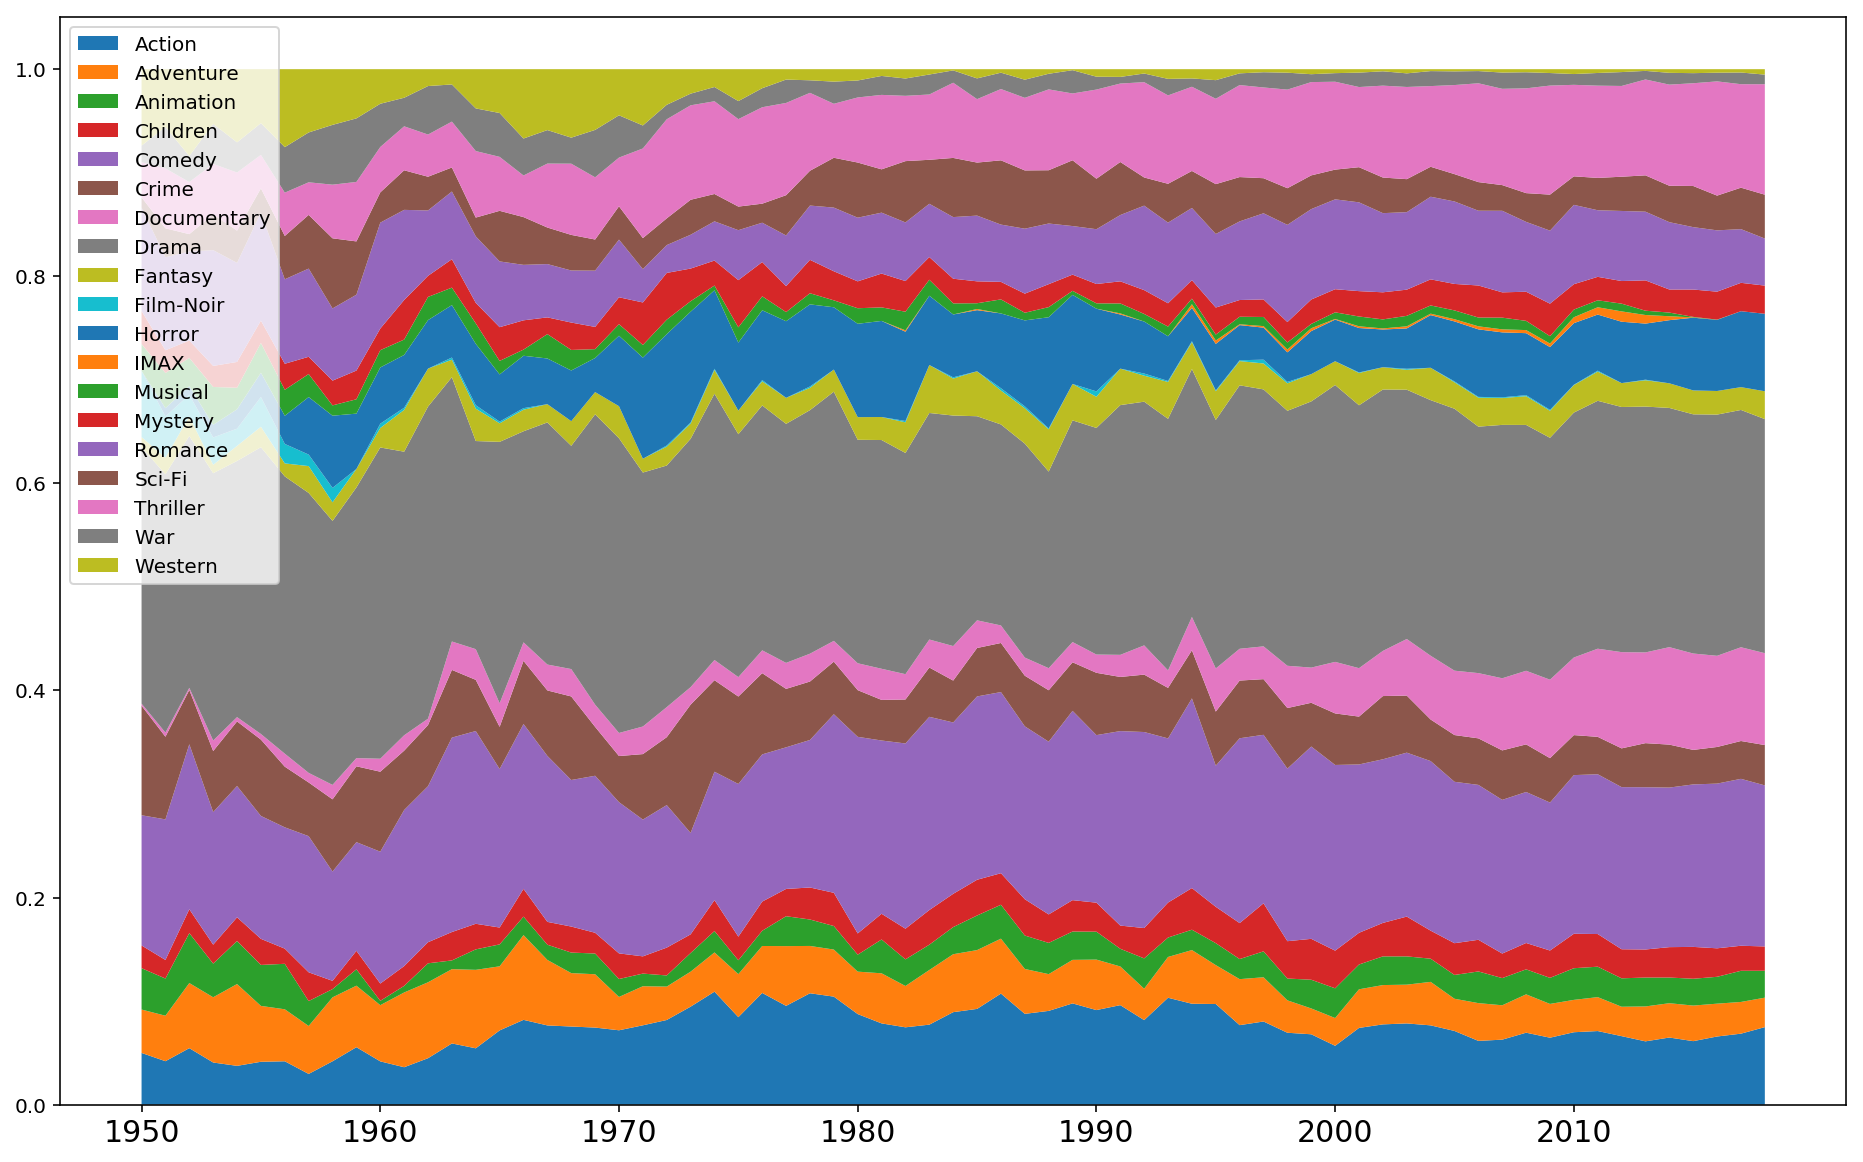

In [63]:
f, ax = plt.subplots(figsize=(16, 10))

ax.stackplot(years, parts, labels=unique_topics)
ax.legend(loc='upper left')
plt.xticks(years[::10], fontsize=15)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [64]:
movie_to_info = tmdb\
    .filter(lambda data: "id" in data)\
    .map(lambda data: (data["id"], (int(data["revenue"]), int(data["budget"]))))\
    .filter(lambda data: data[1][0] != 0 and data[1][1] != 0)\
    .join(tmdb_to_id)\
    .map(lambda data: (data[1][1], (data[1][0][0], data[1][0][1])))

In [65]:
roi_info = sc.textFile(MOVIES_PATH)\
    .map(lambda s: s.split(','))\
    .map(lambda s: (s[0], s[-1]))\
    .filter(lambda kv: kv[1] and kv[1] != 'genres' and kv[1] != '(no genres listed)')\
    .flatMap(lambda kv: [(int(kv[0]), genre) for genre in kv[1].split("|")])\
    .join(movie_to_info)\
    .map(lambda kv: (kv[1][0], (kv[1][1][0], kv[1][1][1])))\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .map(lambda kv: (kv[0], kv[1][0] / kv[1][1]))\
    .sortBy(lambda kv: kv[1], ascending=False)\
    .collect()

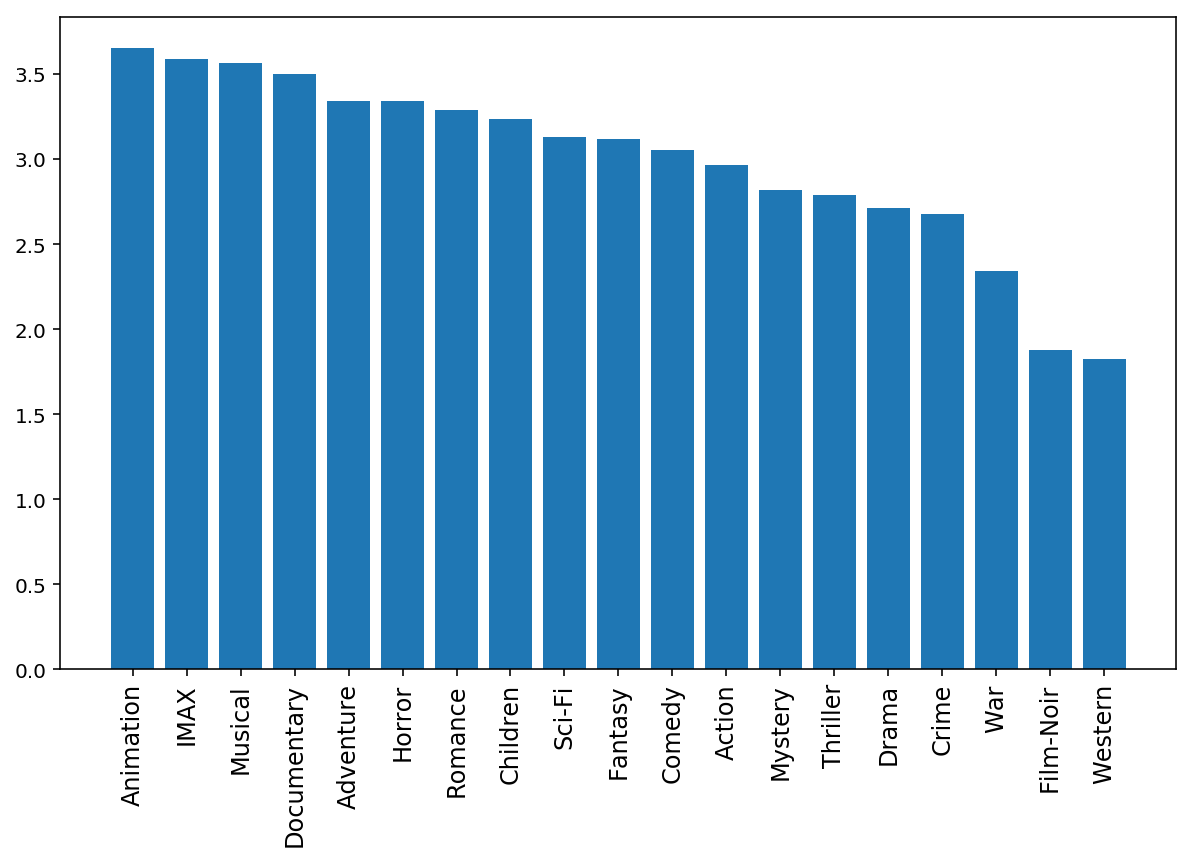

In [66]:
keys, values = zip(*roi_info)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=90, fontsize=12)
plt.bar(keys, values, align="center")
plt.show()

In [67]:
(1, 2, 3) + (4, 5, 6)

(1, 2, 3, 4, 5, 6)